## Trajectory Optimization with Differentiable Physics

### Imports

In [1]:
import os
from copy import deepcopy as dc
# math
import numpy as np
# physics
import warp as wp
import warp.sim as wps
# graphics
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# setup
wp.init()
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

Warp 0.15.1 initialized:
   CUDA Toolkit 11.5, Driver 11.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce GTX 1050 Ti with Max-Q Design" (4 GiB, sm_61, mempool enabled)
   Kernel cache:
     /home/jonathan/.cache/warp/0.15.1
Mitsuba 3 Variant: llvm_ad_rgb


### Setup

In [2]:
#########
# Scene #
#########

# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# ground
ground = True

# particle
particle_init_pos = np.array([-0.5, 1.0, 0.0])
particle_init_vel = np.array([5.0, -5.0, 0.0])
particle_radius = 0.2
particle_mass = 1.0
particle_rgb = np.array([0.2, 0.25, 0.7])

# wall
wall_pos = np.array([2.0, 1.0, 0.0])
wall_extents = np.array([0.25, 1.0, 1.0])
wall_rgb = np.array([0.7, 0.25, 0.2])

# target
target_pos = np.array([-2.0, 1.5, 0.0])

# contact parameters
ke = 1.0e4
kf = 0.0
kd = 1.0e1
mu = 0.2
rt = 1.0
margin = 10.0


##############
# Simulation #
##############

sim_duration = 0.6
# control frequency
fps = 60
frame_dt = 1.0 / float(fps)
frame_steps = int(sim_duration / frame_dt)
# sim frequency
sim_substeps = 8
sim_steps = frame_steps * sim_substeps
sim_dt = frame_dt / sim_substeps


def build_sim():
    device = wp.get_cuda_devices()[0]

    builder = wps.ModelBuilder()
    # particle
    builder.add_particle(pos=particle_init_pos, vel=particle_init_vel, radius=particle_radius, mass=particle_mass)
    # wall
    builder.add_shape_box(body=-1, 
                          pos=wall_pos, 
                          hx=wall_extents[0], hy=wall_extents[1], hz=wall_extents[2], 
                          ke=ke, kf=kf, kd=kd, mu=mu)
    model = builder.finalize(device)

    model.ground = ground
    model.soft_contact_ke = ke
    model.soft_contact_kf = kf
    model.soft_contact_kd = kd
    model.soft_contact_mu = mu
    model.soft_contact_margin = margin
    model.soft_contact_restitution = rt

    integrator = wp.sim.SemiImplicitIntegrator()

    # allocate sim states for trajectory
    states = [model.state(requires_grad=True) for _ in range(sim_steps + 1)]

    # one-shot contact creation
    wp.sim.collide(model, states[0])

    return device, integrator, model, states


def get_trajectory(states):
    trajectory = []
    for state in states[::sim_substeps]:
        trajectory.append(state.particle_q.numpy().squeeze())
    return np.array(trajectory)


#############
# Rendering #
#############

img_width = 128
img_height = 128
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

direct_traj_scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': particle_rgb
            }
        }
    },
    'wall': {
        'type': 'cube',
        'to_world': mit.translate(wall_pos).scale(wall_extents),
        'bsdf' : {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': wall_rgb
            }
        }
    },
    "ground": {
        "type": "rectangle",
        "to_world": mit.rotate(axis=[1.0, 0.0, 0.0], angle=-90).scale(20),
        "bsdf": {
            "type": "diffuse",
            'reflectance': {
                'type': 'checkerboard',
                'to_uv': mi.ScalarTransform4f.scale([10, 10, 1])
            }
        }
    }
}


################
# Optimization #
################

@wp.kernel
def direct_loss_kernel(pos: wp.array(dtype=wp.vec3), target: wp.vec3, loss: wp.array(dtype=float)):
    # distance to target
    delta = pos[0] - target
    loss[0] = wp.dot(delta, delta)

@wp.kernel
def direct_step_kernel(x: wp.array(dtype=wp.vec3), grad: wp.array(dtype=wp.vec3), alpha: float):
    tid = wp.tid()

    # gradient descent step
    x[tid] = x[tid] - grad[tid] * alpha

def direct_compute_loss(device, model, integrator, states, loss):
    # run control loop
    for i in range(sim_steps):
        states[i].clear_forces()

        integrator.simulate(model, states[i], states[i + 1], sim_dt)

    # compute loss on final state
    wp.launch(direct_loss_kernel, dim=1, inputs=[states[-1].particle_q, target_pos, loss], device=device)

def direct_build_optim(device, model, integrator, states):
    # capture forward/backward passes
    loss = wp.zeros(1, dtype=wp.float32, device=device, requires_grad=True)

    wp.capture_begin()
    tape = wp.Tape()
    with tape:
        direct_compute_loss(device, model, integrator, states, loss)
    tape.backward(loss)
    graph = wp.capture_end()

    return graph, tape, loss

def direct_run_sim(graph, tape):
    with wp.ScopedTimer("Run", print=False):
        # forward + backward
        wp.capture_launch(graph)

        # clear grads for next iteration
        tape.zero()

def direct_optim_params(device, states, graph, tape, train_rate):
    with wp.ScopedTimer("Step", print=False):
        # forward + backward
        wp.capture_launch(graph)

        # gradient descent step
        x = states[0].particle_qd
        wp.launch(direct_step_kernel, dim=len(x), inputs=[x, x.grad, train_rate], device=device)

        # clear grads for next iteration
        tape.zero()

### States

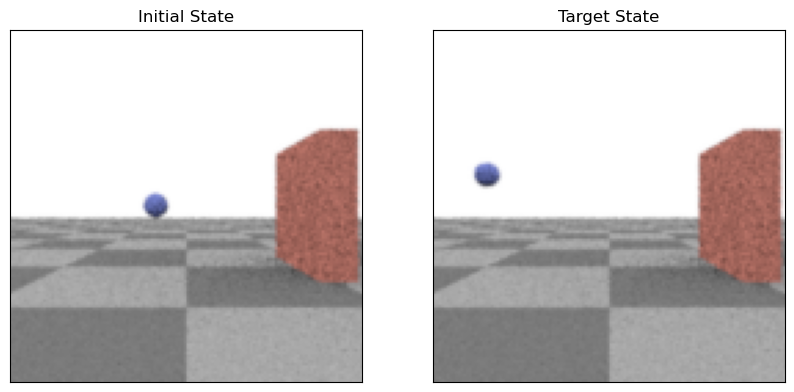

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

##########
# States #
##########

init_scene_dict = dict(direct_traj_scene_dict)
init_scene_dict['particle']['center'] = dc(particle_init_pos)
bitmap_init = mi.util.convert_to_bitmap( mi.render(mi.load_dict(init_scene_dict), spp=16))
axs[0].imshow(bitmap_init)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Initial State')

target_scene_dict = dict(direct_traj_scene_dict)
target_scene_dict['particle']['center'] = dc(target_pos)
bitmap_target = mi.util.convert_to_bitmap(mi.render(mi.load_dict(target_scene_dict), spp=16))
axs[1].imshow(bitmap_target)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Target State')

plt.show()
#plt.savefig('fig_direct_traj_states.pdf', bbox_inches='tight')

### Optimization

In [4]:
train_iters = 250
train_rate = 0.02
train_save_interval = 50

sim_device, phys_integrator, model, states = build_sim()
graph, tape, loss = direct_build_optim(sim_device, model, phys_integrator, states)
# initial run to set init trajectory and loss.
direct_run_sim(graph, tape)

vel_trajs = [get_trajectory(states)]
vel_losses = [loss.numpy()[0]]
for i in range(train_iters):
    direct_optim_params(sim_device, states, graph, tape, train_rate)
    vel_losses.append(loss.numpy()[0])

    if (i+1) % train_save_interval == 0:
        print("Iteration: {}, Loss: {}".format(i+1, vel_losses[-1]))
        vel_trajs.append(get_trajectory(states))

Module warp.sim.collide load on device 'cuda:0' took 151.67 ms
Module warp.utils load on device 'cuda:0' took 4.45 ms
Module warp.sim.inertia load on device 'cuda:0' took 14.71 ms
Module warp.sim.model load on device 'cuda:0' took 0.20 ms
Module warp.sim.optimizer load on device 'cuda:0' took 1.69 ms
Module warp.sim.particles load on device 'cuda:0' took 4.76 ms
Module warp.sim.utils load on device 'cuda:0' took 16.92 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 125.12 ms
Module warp.sim.integrator_xpbd load on device 'cuda:0' took 198.73 ms
Module warp.sim.articulation load on device 'cuda:0' took 61.91 ms
Module __main__ load on device 'cuda:0' took 1.25 ms
Iteration: 50, Loss: 0.5825151801109314
Iteration: 100, Loss: 0.05657896772027016
Iteration: 150, Loss: 0.002243348164483905
Iteration: 200, Loss: 0.0007570484885945916
Iteration: 250, Loss: 0.0006764723802916706


### Results

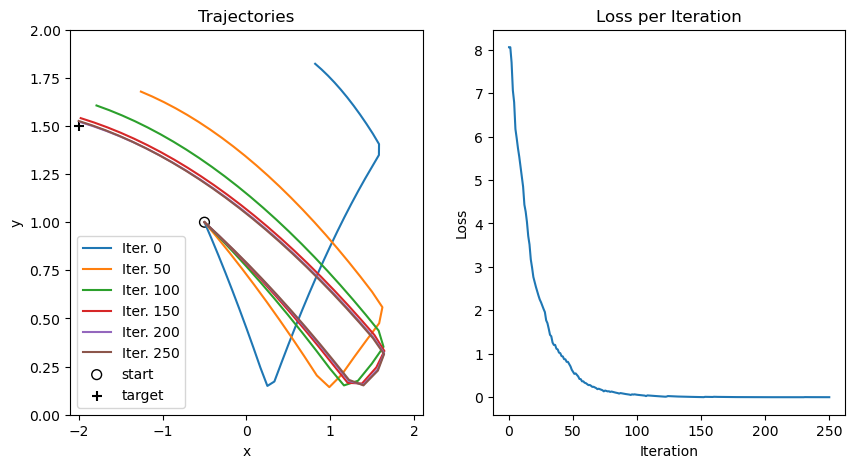

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

################
# Trajectories #
################

axs[0].set_title('Trajectories') 
for i, vel_traj in enumerate(vel_trajs):
    axs[0].plot(vel_traj[:, 0], vel_traj[:, 1], label=f'Iter. {i*train_save_interval}')
axs[0].scatter(particle_init_pos[0], particle_init_pos[1], label='start', facecolors='none', edgecolors='black', s=50)
axs[0].scatter(target_pos[0], target_pos[1], color='black', label='target', marker='+', s=50)
axs[0].set_xlim([-2.1, 2.1])
axs[0].set_ylim([0.0, 2.0])
axs[0].set_xlabel('x');
axs[0].set_ylabel('y');
axs[0].legend(loc='lower left' )


##########
# Losses #
##########

axs[1].plot(vel_losses)
axs[1].set_xlabel('Iteration'); 
axs[1].set_ylabel('Loss'); 
axs[1].set_title('Loss per Iteration')

plt.show()
#plt.savefig('fig_direct_traj_optim.pdf', bbox_inches='tight')